In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Normalization
import numpy as np
from sklearn.model_selection import train_test_split,KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tf2onnx
from os import path

In [10]:
with open(path.join("results","results.csv")) as f:
    results = f.readlines()
    
strings = ["h_E", "B", "G", "D", "A", "E"]
labels = np.array([0,1,2,3,4,5])

data = []
label_list = []

for i, line in enumerate(results):
    if i == 0:
        continue
    string,metric,amp_ra,deviation,f0 = line.split(",")
    if string in strings:
        metric = float(metric)
        amp_ra = float(amp_ra)
        deviation = float(deviation)
        f0 = float(f0)
        data.append([metric,amp_ra, deviation,f0])
        label_list.append(labels[strings.index(string)])


data = np.array(data, dtype=np.float32)
label_list = np.array(label_list)




label_count = 6
labels_categorical = tf.keras.utils.to_categorical(label_list, num_classes=label_count)


X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 2)
print(f"Training labels shape: {y_train.shape}")

Training data shape: (1415, 4)
Training labels shape: (1415, 6)


In [11]:
#normalize data
normalization_layer = Normalization(input_shape=(X_train.shape[1],))
normalization_layer.adapt(X_train)

c:\Program Files\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model = Sequential([
    normalization_layer,
    Dense(55, activation='relu'),
    BatchNormalization(),  # Helps stabilize training
    Dropout(0.3),
    
    Dense(55, activation='relu'),
    #Dense(55, activation='relu'),
    Dense(52, activation='relu'),
    
    Dense(55, activation='sigmoid'),

   
    Dense(label_count, activation='softmax')
])
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00008), metrics=['accuracy'])

# Train the model

print(model.summary())

#implement early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', patience=100, restore_best_weights=True)
# with tf.device('/GPU:0'):
history = model.fit(X_train, y_train, epochs=700, batch_size=30, validation_split=0.2,callbacks=early_stopping)
    

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 4)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 55)             │           275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 55)             │           220 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 55)             │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 52)             │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 55)             │         2,915 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 6)              │           336 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,747 (38.08 KB)

 Trainable params: 9,628 (37.61 KB)

 Non-trainable params: 119 (480.00 B)

None
Epoch 1/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1686 - loss: 1.8833 - val_accuracy: 0.1837 - val_loss: 1.8627
Epoch 2/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1821 - loss: 1.8197 - val_accuracy: 0.1837 - val_loss: 1.8367
Epoch 3/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1826 - loss: 1.7827 - val_accuracy: 0.1837 - val_loss: 1.8119
Epoch 4/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2295 - loss: 1.7412 - val_accuracy: 0.1837 - val_loss: 1.7877
Epoch 5/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3006 - loss: 1.7033 - val_accuracy: 0.1837 - val_loss: 1.7616
Epoch 6/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4043 - loss: 1.6736 - val_accuracy: 0.2580 - val_loss: 1.7302
Epoch 7/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4661 - loss: 1.6236 - val_accuracy: 0.4205 - val_loss: 1.6949
Epoch 8/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4357 - loss: 1.6011 - val_accuracy: 0.431

KeyboardInterrupt: 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


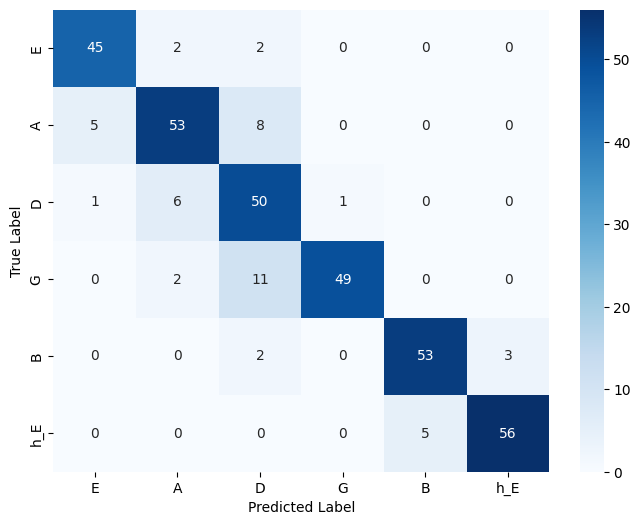

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

stringnames = ["E", "A", "D", "G", "B", "h_E"]
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=stringnames, yticklabels=stringnames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
#test model with new data
with open(path.join("results","testresults.csv")) as f:
    new_data = f.readlines()
correct_strings = 0
for line in new_data:
    string,metric,amp_ra,deviation,f0 = line.split(",")
    if string in strings:
        metric = float(metric)
        amp_ra = float(amp_ra)
        deviation = float(deviation)
        f0 = float(f0)
        topredict = [metric,amp_ra, deviation,f0]
        topredict = np.array(topredict, dtype=np.float32)
        topredict = topredict.reshape(1,4)
        prediction = model.predict(topredict)
        # print(f"String: {string}")
        # print(f"Predicted string: {strings[np.argmax(prediction)]}")
        # print(f"Confidence: {np.max(prediction)}")
        if string == strings[np.argmax(prediction)]:
            correct_strings += 1
        print("\n\n")

print(f"Correct strings: {correct_strings}")
#new_data = normalization_layer(new_data)
#print(model.predict(new_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



1/1 ━━━━━━━━━━━━

In [15]:
model.save('stringDetectionML.h5')

import os
from os import path
model.output_names=['output']
input_signature = [tf.TensorSpec(model.inputs[0].shape, tf.float32, name='digit')]
print(model.inputs[0].shape) 

(onnx_model_proto, storage) = tf2onnx.convert.from_keras(model,input_signature=input_signature, opset=13)

dir = os.getcwd()
dir = dir.split("/")[0]
while( path.basename(dir) != "TabGenerator"): # go to the TabGenerator directory
    dir = os.path.dirname(dir)

dir = os.path.join(dir, "Assets","MachineLearning","MLModels")
onnxpath_asset_folder = os.path.join(dir, "stringDetectionML_ONNX.onnx")

with open(onnxpath_asset_folder, "wb") as f:
    f.write(onnx_model_proto.SerializeToString())


#export the model to local folder
onnx_path = os.path.join("models", "stringDetectionML_ONNX.onnx")
with open(onnx_path, "wb") as f:
    f.write(onnx_model_proto.SerializeToString())

(None, 4)


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x000002B43B9AB640>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
